#Op Return

<a href="https://colab.research.google.com/github/ProfDoeg/Colegio_Invisible/blob/master/11_cuaderno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparar el Espacio (Prepare the Space)

In [7]:
! pip install eciespy eth_keys cryptos qrcode base58 
! git clone https://github.com/ProfDoeg/Colegio_Invisible.git

fatal: destination path 'Colegio_Invisible' already exists and is not an empty directory.


# Crear Transacciones de Criptomoneda (Create Cryptocurrency Transactions)

## Esquema (Outline) 

***

 
## Metas (Goals)
***
***
By the end of this notebook you should be able to:
***
Al final de este cuaderno, usted debería ser capaz de:
***
***
- Multisig
-

# Importaciones y Definiciones (Imports and Definitions)

Crear funciones para importar claves y direcciones de criptomonedas.
***
Create functions for importing keys and cryptocurrency addresses.

In [9]:
import pandas as pd
from cryptos.py3specials import safe_hexlify, from_string_to_bytes, from_int_to_byte, from_string_to_bytes
from cryptos import serialize,deserialize

import hashlib
import os
import getpass
import ecies
import eth_keys
import cryptos
import qrcode
import base58
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def import_privKey(privkey_filepath,password=None):
    if password==None:
        password = getpass.getpass("Input password for decrypting keyfile: ")
    password=password.encode()
    f=open(privkey_filepath,'rb')
    decrypted_bytes=ecies.aes_decrypt(key=hashlib.sha256(password).digest(),cipher_text=f.read())
    privKey=eth_keys.keys.PrivateKey(decrypted_bytes)
    return privKey

def import_pubKey(pubkey_filepath):
    f=open(pubkey_filepath,'rb')
    privKey=eth_keys.keys.PublicKey(f.read())
    return privKey

def import_addr(addr_filepath):
    return open(addr_filepath,'rb').read().decode()

def only_conf(utxos):
    return [utxo for utxo in utxos
            if doge.fetchtx(utxo['output'].split(':')[0])['confirmations']>1]

def mk_opreturn(msg, rawtx=None, json=0):
    
    def op_push(data):
        if type(data) == bytes:
            bytedata=data
        else:
            bytedata=data.encode()
        import struct
        if len(data) < 0x4c:
            return from_int_to_byte(len(bytedata)) + bytedata
        elif len(data) < 0xff:
            return from_int_to_byte(76) + struct.pack('<B', len(bytedata)) + bytedata
        elif len(data) < 0xffff:
            return from_int_to_byte(77) + struct.pack('<H', len(bytedata)) + bytedata
        elif len(data) < 0xffffffff:
            return from_int_to_byte(78) + struct.pack('<I', len(bytedata)) + bytedata
        else: raise Exception("Input data error. Rawtx must be hex chars" \
                            + "0xffffffff > len(data) > 0")

    orhex = safe_hexlify(b'\x6a' + op_push(msg))
    orjson = {'script' : orhex, 'value' : 0}
    if rawtx is not None:
        try:
            txo = deserialize(rawtx)
            if not 'outs' in txo.keys(): raise Exception("OP_Return cannot be the sole output!")
            txo['outs'].append(orjson)
            newrawtx = serialize(txo)
            return newrawtx
        except Exception as E:
            print(E)
            print(type(E))
            raise Exception("Raw Tx Error!")
    return orhex if not json else orjson

# Comenzar con Claves Existentes (Start with Existing Keys)

Acceder a las claves generadas en el cuaderno 5
***
Access the keys generated in the cuaderno 5

## Comenzar con Claves en Google Drive (Start with Keys on Google Drive)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
! cp drive/MyDrive/cinv/llaves.zip llaves.zip 
! unzip llaves.zip


Archive:  llaves.zip
   creating: llaves/
 extracting: llaves/mi_addr.bin      
 extracting: llaves/mi_addr.png      
 extracting: llaves/mi_pub.bin       
 extracting: llaves/mi_prv.enc       


## Comenzar con Claves en la Disco Local
## (Start with Keys on Local Drive)

In [ ]:
#from google.colab import files
#fu=files.upload();

In [ ]:
#! unzip llaves.zip

In [ ]:
#! ls llaves

# Import Private Key, Public Key and Address

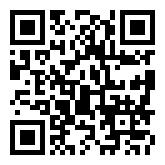

'0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5'

'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX'

In [13]:
from IPython.display import Image
qr=Image('llaves/mi_addr.png')

privKey=import_privKey('llaves/mi_prv.enc','')
pub=import_pubKey('llaves/mi_pub.bin').to_hex()
addr=import_addr('llaves/mi_addr.bin')

display(qr)
display(pub)
display(addr)

# Import 

# Connect to Colegio Message Spreadsheet

## Decrypt Credentials

$\color{white}{\text{c0leg101nv1s1ble}}$

Use la contraseña de arriba para descifrar las credenciales
***
Use password above to decrypt credentials


In [14]:
! python Colegio_Invisible/scripts/aes_decrypt.py c0leg101nv1s1ble Colegio_Invisible/secrets/client_secret.aes Colegio_Invisible/secrets/client_secret.json 

Éxito (Success): Colegio_Invisible/secrets/client_secret.aes decifrado con éxito (decryption complete)
Escrito a (Written to): Colegio_Invisible/secrets/client_secret.json


## Autenticar y Conectarse a la Google Sheet de Mensajes (Authenticate and Connect to Message Google Sheet)

Autenticarse usando credenciales descifradas para la API de Google Drive.\
Use la biblioteca `gspread` para leer y escribir en una hoja de cálculo compartida.
***
Authenticate using decrypted credentials for Google Drive API.\
Use `gspread` library to read and write to shared spreadsheet.

In [15]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('Colegio_Invisible/secrets/client_secret.json', scope)
client = gspread.authorize(creds)
sheets = client.open("signatures")

# Leer y Escribir en la Google Sheet de Mensajes (Read and Write to Messages Google Sheet)

## Leer Google Sheet (Read Google Sheet)

In [16]:
sheet4=sheets.worksheets()[4]
sheet4.row_values(1)

['name', 'address', 'pubkey']

In [ ]:
#sheet4.clear()
#sheet4.append_row(["name", "address","pubkey"])

## Ingresar el Nombre (Input Name)

In [17]:
my_name=input('input name')

input nameDrDoeg


## Leer Nombres Publicados (Read Posted Names)

In [18]:
peeps=sheet4.col_values(1)[1:]
peeps

['DrDoeg', 'Laura']

## Escribir en la Google Sheet para Publicar Nombre (Write to Google Sheet to Publish Name)

Si el nombre está en la lista, escriba la dirección en la celda correspondiente de la hoja\
Si el nombre no está presente, agregue el nombre y la dirección a la hoja
***
If the name is in the list then write address to the appropriate cell of sheet\
If name is not present append name and address to sheet

In [19]:
pub

'0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5'

In [20]:
addr

'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX'

In [21]:
if not (my_name in peeps) :
  sheet4.append_row([my_name,addr,pub])
else:
  sheet4.update_cell(row=peeps.index(my_name)+2,col=2,value=addr)
  sheet4.update_cell(row=peeps.index(my_name)+2,col=3,value=pub)

## Leer Claves Publicas (Read Public Keys)

In [22]:
import pandas as pd

sheet4=sheets.worksheets()[4]
dataframe4 = pd.DataFrame(sheet4.get_all_records())
display(dataframe4)

pubs = dataframe4.pubkey.tolist()
pubs = [ '04'+pb[2:] for pb in pubs ]
display(pubs)

,name,address,pubkey
0,DrDoeg,D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX,0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b648...
1,Laura,DJBkcc9zShCCWPTvPuLUiHQegNPbmMipEH,0x2478459160f8e4563ad84a1faa998158c2e47b3c8eac...


['047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5',
 '042478459160f8e4563ad84a1faa998158c2e47b3c8eac04654ca30f892d4c873db08339cabb0f5c775f1f798919ab4ce5772666a88ea39cf811b73c95d28ee9f9']

# Make Transaction to Self with op_return



In [43]:
doge=cryptos.Doge()
mi_unspents=doge.unspent(addr)
mi_unspents

[{'output': 'fcea383e211a1019b370e9c832455d251f965639db67144903c6315afdbdea14:0',
  'value': 2000000000}]

In [44]:
doge.unspent('DJBkcc9zShCCWPTvPuLUiHQegNPbmMipEH')

[{'output': '76056897b2e32d482b4f1b2557be51db98a1298f7fb5c651ae3aa2c2974b5dc5:0',
  'value': 1000000000}]

In [45]:
mi_unspent_total=sum([unspent['value'] for unspent in mi_unspents])
mi_unspent_total

2000000000

In [46]:
mining_fee=1_00_000_000
mi_gift=mi_unspent_total-mining_fee

In [47]:
mi_outputs=[{'value':mi_gift , 'address': addr}]
mi_outputs

[{'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX', 'value': 1900000000}]

In [48]:
mi_tx=doge.mktx(mi_unspents,mi_outputs)
mi_tx

{'ins': [{'amount': 2000000000,
   'outpoint': {'hash': 'fcea383e211a1019b370e9c832455d251f965639db67144903c6315afdbdea14',
    'index': 0},
   'script': '',
   'sequence': 4294967295}],
 'locktime': 0,
 'outs': [{'script': '76a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac',
   'value': 1900000000}],
 'version': 1}

In [49]:
mi_serial_tx=cryptos.serialize(mi_tx)

In [50]:
mi_inscribed_serial_tx=mk_opreturn(bytes.fromhex('b1b547c90081c1cdf636e36685122339f8adf603')+'🐶🐴'.encode(), mi_serial_tx)
mi_inscribed_serial_tx

'010000000114eabdfd5a31c603491467db3956961f255d4532c8e970b319101a213e38eafc0000000000ffffffff0200b33f71000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac00000000000000001e6a1cb1b547c90081c1cdf636e36685122339f8adf603f09f90b6f09f90b400000000'

In [51]:
mi_inscribed_tx=cryptos.deserialize(mi_inscribed_serial_tx)
mi_inscribed_tx

{'ins': [{'outpoint': {'hash': 'fcea383e211a1019b370e9c832455d251f965639db67144903c6315afdbdea14',
    'index': 0},
   'script': '',
   'sequence': 4294967295}],
 'locktime': 0,
 'outs': [{'script': '76a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac',
   'value': 1900000000},
  {'script': '6a1cb1b547c90081c1cdf636e36685122339f8adf603f09f90b6f09f90b4',
   'value': 0}],
 'version': 1}

In [53]:
mi_signed_inscribed_tx=doge.signall(mi_inscribed_tx,privKey.to_hex()[2:])
mi_signed_inscribed_tx

'010000000114eabdfd5a31c603491467db3956961f255d4532c8e970b319101a213e38eafc000000008b483045022100d2bdbdc3aae98b5789eebcb6b04d0da0d5eda0d2b59cc3e94c3f1be5a9c630c902201c5406a72f3017f2d3da0756fbf6d6f576c43ba27a1dcadaaa2ed61aadcb07e20141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5ffffffff0200b33f71000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac00000000000000001e6a1cb1b547c90081c1cdf636e36685122339f8adf603f09f90b6f09f90b400000000'

In [54]:
broadcast_mi_txn=doge.pushtx(mi_signed_inscribed_tx)
broadcast_mi_txn

{'data': {'network': 'DOGE',
  'txid': 'f026d68ddd2a4388448c0bcdc12c16c6b0a9a2ba4cca3ae1e0f5766d21feb5cf'},
 'status': 'success'}

In [66]:
doge.fetchtx(broadcast_mi_txn['data']['txid'])

{'blockhash': 'c5662642bbbae021d6e94933e2f2b4c878921978e07ba6163b760c3383576f72',
 'confirmations': 7,
 'inputs': [{'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
   'from_output': {'output_no': 0,
    'txid': 'fcea383e211a1019b370e9c832455d251f965639db67144903c6315afdbdea14'},
   'input_no': 0,
   'script': '3045022100d2bdbdc3aae98b5789eebcb6b04d0da0d5eda0d2b59cc3e94c3f1be5a9c630c902201c5406a72f3017f2d3da0756fbf6d6f576c43ba27a1dcadaaa2ed61aadcb07e201 047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5',
   'sequence': 4294967295,
   'type': 'pubkeyhash',
   'value': '20.00000000',
   'witness': None}],
 'locktime': 0,
 'network': 'DOGE',
 'network_fee': '1.00000000',
 'outputs': [{'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
   'output_no': 0,
   'script': 'OP_DUP OP_HASH160 144739367df0ff8d1c61d03704298d49cf93ef3f OP_EQUALVERIFY OP_CHECKSIG',
   'type': 'pubkeyhash',
   'value': '19.00000000'},
  {'a

In [65]:
op_tx_data=doge.fetchtx(broadcast_mi_txn['data']['txid'])
op_hex=[output['script'][10:] for output in op_tx_data['outputs'] if 'OP_RETURN' in output['script'] ][0]
bytes.fromhex(op_hex[-16:]).decode(),op_hex[:-16]

('🐶🐴', 'b1b547c90081c1cdf636e36685122339f8adf603')

# Create the Multisig Address

## Importar 'cryptos' y Crear un Objeto de Dogecoin (Import `cryptos` and Create Dogecoin Object)

In [67]:
import cryptos
doge=cryptos.Doge()
doge.script_magicbyte=22
multi_tup=doge.mk_multsig_address(pubs,2)
multi_script,multi_addr=multi_tup
display(multi_script)
display(multi_addr)

'5241047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c541042478459160f8e4563ad84a1faa998158c2e47b3c8eac04654ca30f892d4c873db08339cabb0f5c775f1f798919ab4ce5772666a88ea39cf811b73c95d28ee9f952ae'

'9vvCKFQYC4r4C3ZUsNZqyxkxV4YgFEiNDg'

# Create a Transaction from Funded MultiSig

## Las Entradas (Inputs)

### Identificar la Dirección de Financiación (Identify Funding Address)

### Determinar las Entradas de UTXO (Determine UTXO Inputs)

***
***
Los UTXO son salidas de transacciones no gastadas. Comenzamos revisando la cadena de bloques para identificar las monedas que la dirección de financiación ha recibido pero que aún no ha gastado. Estos son UTXO.
***
UTXOs are Unspent Transaction Outputs. We start by checking the blockchain to identify coins the funding address has received but has not yet spent. These are UTXOs. 
***
***

Cada UTXO contiene (each UTXO contains):
- valor (value)
- transacción (transaction)
  - hash (hash)
  - índice (index)

In [68]:
#UTXOS
unspents=doge.unspent(multi_addr)
unspents

[{'output': 'e264669f5be88cb5bb678ec74e5fbb9b428c1400ce6d339ee25e6443cbf03a9d:0',
  'value': 1800000000}]

### Satoshis

El valor se informa en unidades de Satoshis/Dogetoshis. Un Satoshi es un $\frac{1}{100,000,000}$ de una moneda.
***
The value is reported in units of Satoshis/Dogetoshis. A Satoshi is $\frac{1}{100,000,000}$ of a coin.

### Sumar Salidas No Gastadas (Sum Unspent Outputs)

In [73]:
unspent_total=sum([unspent['value'] for unspent in unspents])
unspent_total

1800000000

## Salidas (Outputs)

### Calcular Valores de Salida (Calculate Output Values)

- `mining_fee`: cantidad entregada a los mineros\
(amount given to miners)
- `change`: cantidad sobrante que el remitente enviará a una dirección de cambio\
(the left over amount that the sender will send to a change address)

In [74]:
mining_fee = 1_00_000_000
gift = unspent_total - mining_fee
gift

1700000000

### Construir Lista de Salidas (Construct Output List)
***
***
Crear salidas que incluyan:
***
Create outputs including:
***
***
- `gift` regalo a nos\
 (`gift` to us)

In [75]:
outputs=[{'value': gift, 'address': multi_addr}]
outputs

[{'address': '9vvCKFQYC4r4C3ZUsNZqyxkxV4YgFEiNDg', 'value': 1700000000}]


## Hacer Transacción  (Make MultiSig Transaction)

In [76]:
self_txn=doge.mktx(unspents,outputs )
self_txn

{'ins': [{'amount': 1800000000,
   'outpoint': {'hash': 'e264669f5be88cb5bb678ec74e5fbb9b428c1400ce6d339ee25e6443cbf03a9d',
    'index': 0},
   'script': '',
   'sequence': 4294967295}],
 'locktime': 0,
 'outs': [{'script': 'a9143128856aefebe150d940ad7e0c76b4f3f88218ca87',
   'value': 1700000000}],
 'version': 1}

## Firmar Transacción de Financiamiento (Sign Multisig Transaction)

In [ ]:
doge.sign()

In [ ]:
sig_me=doge.multisign(tx=self_txn, i=0, script=multi_script, pk=privKey.to_hex()[2:])
sig_me

In [ ]:
sig_2='304402207b421e91d8d39056fd0ad01a35668e83ffe7429661257c5ee78120f85213957c022015a7ba39449332df9f8e0c0813a31c2e355611dc6c12aa1684ccc72c6f1780e201'

In [ ]:
cryptos.apply_multisignatures(self_txn, 0, multi_script,sig_me,sig_2)

In [ ]:
self_txn

In [ ]:
multisig_hex=cryptos.serialize(self_txn)
multisig_hex

In [ ]:
broadcast_multi_txn=doge.pushtx(multisig_hex)
broadcast_multi_txn

In [ ]:
broadcast_multi_txn['data']['txid']

In [ ]:
doge.fetchtx(broadcast_multi_txn['data']['txid'])